In [1]:
import numpy as np
import pygame
import pandas as pd
import random
from subprocess import Popen, PIPE, STDOUT
import gymnasium as gym
from gymnasium import spaces
import time

class BasketballEnv(gym.Env):
	#metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

	def __init__(self, render_mode=None ):
		#self.size = size  # The size of the square grid
		
		self.number_to_character = {'0' : 'Alice', '1':'Bob' , '2':'Charlie','3':'Sherlock','4':'?'}
		self.character_to_number = {v: k for k, v in self.number_to_character.items()}
													
		self.number_to_place = {'0' : 'HomeB', '1':'BasketballCourt' , '2':'Downtown','3':'?'}
		self.place_to_number = {v: k for k, v in self.number_to_place.items()}

		self.number_to_item = {'0' : 'Basketball', '1':'Bat','2':'?' }
		self.item_to_number = {v: k for k, v in self.number_to_item.items()}

		self.number_to_crime = {'0' : 'Theft', '1':'Murder','2':'?' }
		self.crime_to_number = {v: k for k, v in self.number_to_crime.items()}

		
		#self._nb_features = 39
		self.score = 0
		self.characters = ['Alice', 'Bob', 'Charlie','Sherlock']
		self.items = ['Basketball','Bat']
		self.places= ['HomeB','BasketballCourt','Downtown']
		self.crimes = ['Theft','Murder']

		self.utilities = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':'(sum(c : citizen) underArrest(c)); \n',
		}

		self.utilities1 = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':'(sum(c : citizen) underArrest(c)); \n',
		}

		self.utilities2 = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':' (sum(p : place) searched(p)); \n',


		}
		"""
		self.characters = ['0','1','2','3']
		self.items = ['0','1']
		self.places= ['0','1','2']
		self.crimes = ['0','1']
		self.utilities = {
			'0':'1 - angry(Alice);\n',
			'1':'3 - (sum(c : citizen) angry(c));\n',
			'2':'if(!alive(Alice)) 1 else 0;\n',
			'3':'(sum(c : citizen) underArrest(c)) + (sum(p : place) searched(p)); \n',
		}
		"""
		self.acting_character = self.characters[0]
		self.additional_utility = None
		self.df_effects = pd.read_csv('basketball_effects_nn.csv')
		self.file = 'rl_planner.txt'
		
		self.randomize_df()
		self.df = self.change_number_to_cat(self.df)
		self.create_file(self.df)
		self.no_solution = 0
		self._nb_features = len(self.df.index)
		# Observations are dictionaries with the agent's and the target's location.
		# Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
		self.observation_space = spaces.Box(
			0,
			5,
			shape = [self._nb_features]
		)

		self.target_feature = None
		self.target_value = None

		

		# We have 4 actions, corresponding to choosing character
		self.action_space = spaces.Discrete(5)

		"""
		The following dictionary maps abstract actions from `self.action_space` to
		the direction we will walk in if that action is taken.
		
		"""
		self._action_to_direction = {
			0: 'char0',
			1: 'char1',
			2: 'char2',
			3: 'ut_char3_1',
			4: 'ut_char3_2',
			
		}


		

		

	def change_number_to_cat(self,row):
		for index,value in row.items():
			if ('acting_character' in index)  or ('has' in index) :
				
				row[index] = self.number_to_character[str(value)]
			if ('suspect' in index) :
				
				row[index] = self.number_to_crime[str(value)]
			elif 'at' in index and 'Bat' not in index:
				row[index] = self.number_to_place[str(value)]

		return row

	def change_cat_to_number(self,row):
		for index,value in row.items():
			if ('acting_character' in index) or ('has' in index):
				if str(value) in self.character_to_number.keys():
					row[index] = self.character_to_number[str(value)]
			if ('suspect' in index) :
				if str(value) in self.crime_to_number.keys():
					row[index] = self.crime_to_number[str(value)]
			elif 'at' in index and 'Bat' not in index:
				if str(value) in self.place_to_number.keys():
					row[index] = self.place_to_number[str(value)]

		return row


	def randomize_df(self):
		

		lists = []
		columns = []

		columns.append("acting_character")
		lists.append(self.characters)

		for c in self.characters:
			c= str(c)
			columns.append(c+"_alive")
			lists.append([0,1])

			columns.append(c+"_underArrest")
			lists.append([0,1])

			columns.append(c+"_angry")
			lists.append([0,1])

			columns.append(c+"_suspect")
			lists.append(self.crimes)

			columns.append(c+"_at")
			lists.append(self.places)
		
			
		for p in self.places:
			p = str(p)
			columns.append(p+"_searched")
			lists.append([0,1])

		characters2 = self.characters + ['?']
		for i in self.items:
			i = str(i)
			columns.append(i+"_has")
			lists.append(characters2 )

		for c in self.crimes:
			for i in self.items:
				for p in self.places:
					columns.append(str(c)+"_"+str(i)+"_"+ str(p) +"_clues")
					lists.append([0,0,0,0,0,0,0,0,0,0,0,1])
		

		d = []
		for l in lists:
			d.append(random.choice(l))

		#print(columns)
		d = ['0','1','0','1','2','2','1','0','0','2','0','1','0','1','2','2','1','0','0','2','2','0','0','0','1','2','0','0','0','0','0','0','0','0','0','0','0','0']
		self.df = pd.Series(data = d, index=columns )
		
		
		
	def create_file(self,row):
		acting_character = self.acting_character
		with open(self.file, 'w') as f:
			f.write("""type item;
type place;
type basketballPlace : place;
type arrestPlace : place;
type crime; 
type citizen : character;
type police : character;
type detective : police;
type inspector : police;

property alive(character : character) : boolean;
property underArrest(character : character) : number;
property angry(character : character) : number;
property searched(place : place) : number;
property suspect(character : character, c : crime) : boolean;
property clue(crime : crime, item : item, place : place) : boolean;
property at(character : character) : place;
property has(item : item) : character;

entity Alice : citizen;
entity Bob : citizen;
entity Charlie : citizen;
entity Sherlock : detective;
entity HomeB : place;
entity BasketballCourt : basketballPlace;
entity Downtown : arrestPlace;
entity Basketball : item;
entity Bat : item;
entity Theft : crime;
entity Murder : crime;

		   """
			)
			
			for char in self.characters:
				if str(row[char+"_alive"]) == '1':
					f.write("alive(" + char  +")  ;\n")
				else:
					f.write("!alive(" + char  +")  ;\n")
				f.write("underArrest(" + char  +") = " + str(row[char+"_underArrest"]) + " ;\n")
				f.write("angry(" + char  +") = " + str(row[char+"_angry"]) + " ;\n")
				if str(row[char+"_suspect"]) != '2' and str(row[char+"_suspect"]) != '?':
					f.write("suspect(" + char + ', '+ str(row[char+"_suspect"]) +")   ;\n")
				f.write("at(" + char  +") = " + str(row[char+"_at"]) + " ;\n")

			
				
			for p in self.places:
				f.write("searched(" + p  +") = " + str(row[p+"_searched"]) + " ;\n")
				

			
			for i in self.items:
				f.write("has(" + i  +") = " + str(row[i+"_has"]) + " ;\n")
				
			clues = [x for x in row.index if 'clues' in x]
			
			for c in clues:
				if str(row[c]) == '1':
					print('!!')
					print(str(row[c]))
					print('!!')
					entities = c.split('_')
					f.write("clue(" + entities[0]+","+entities[1]+","+ entities[2] +")   ;\n")
				#warrtosci postaci
			

				
				

			f.write("""
action travel(character : character, from : place, to : place){
	precondition:
		from != to & 
		at(character) == from &
		alive(character);
	effect:
		at(character) = to;
	consenting: character; 
	observing(c : character) : at(c) == from | at(c) == to; 
};

action arrest(police : police, character : character, place : place, crime : crime){
	precondition: 
		at(police) == place &
		at(character) == place &
		police != character &
		alive(police) &
		alive(character) &
		suspect(character, crime);
	effect:
		underArrest(character) = 1;
	consenting: police;
	observing(a : character) : at(a) == place;
};

action steal(thief : citizen, victim : citizen, item : item, place : place){
	precondition:
		at(thief) == place &
		at(victim) == place &
		has(item) == victim &
		thief != victim &
		alive(thief);
	effect:
		has(item) = thief &
		angry(victim) = 1 &
		clue(Theft, item, place);
	consenting: thief;
	observing(c : character) : (c == thief | c == victim) | (at(c) == place & place != Downtown); // crimes downtown aren't observed
};

action play_basketball(player1 : citizen, player2 : citizen, place : basketballPlace){
	precondition:
		player1 != player2 &
		at(player1) == place &
		alive(player1) &
		at(player2) == place &
		alive(player2) &
		has(Basketball) == player1;
	effect:
		angry(player1) = 0 &
		angry(player2) = 0;
	consenting: player1, player2;
	observing(c : character) : at(c) == place;
};

action kill(killer : citizen, victim : citizen, item : item, place : place){
	precondition:
		killer != victim &
		at(killer) == place &
		at(victim) == place &
		alive(killer) &
		alive(victim) &
		has(item) == killer &
		underArrest(killer) == 0;
	effect:
		!alive(victim) &
		clue(Murder, item, place);
	consenting: killer;
	observing(c : character) : c == killer | (at(c) == place & place != Downtown); 
};
	
action find_clues(police : police, crime : crime, item : item, place : place){
	precondition:
		at(police) == place &
		alive(police)
		&clue(crime, item, place);
	effect:
		searched(place) = 1 &
		if(clue(crime, item, place))
			believes(police, clue(crime, item, place));
	consenting: police;
	observing(c : character) : at(c) == place;
};

action share_clues(police1 : police, police2 : police, crime : crime, item : item, place : place){
	precondition:
		police1 != police2 &
		at(police1) == place &
		alive(police1) &
		at(police2) == place &
		alive(police2) &
		clue(crime, item, place);
	effect:
		believes(police2, clue(crime, item, place));
	consenting: police1;
	observing(c : character) : at(c) == place;
};
 
action suspect_of_crime(police : police, citizen : citizen, crime : crime, item : item, place : place){
	precondition:
		police != citizen &
		at(police) == place &
		alive(police) &
		at(citizen) == place &
		alive(citizen) &
		has(item) == citizen &
		exists(p : place) clue(crime, item, p);
	effect:
		suspect(citizen, crime);
	consenting: police;
	observing(c : character) : at(c) == place;
};

trigger see_has(character : character, other : character, item : item, place : place){
	precondition:
		at(character) == place &
		at(other) == place &
		has(item) == other &
		believes(character, has(item) != other);
	effect:
		believes(character, has(item) = other);
};

trigger see_hasnt(character : character, other : character, item : item, place : place){
	precondition:
		at(character) == place &
		at(other) == place &
		has(item) != other & 
		believes(character, has(item) == other);
	effect:
		believes(character, has(item) = ?);
};

trigger see_at(character : character, other : character, place : place){
	precondition:
		at(character) == place &
		at(other) == place &
		believes(character, at(other) != place);
	effect:
		believes(character, at(other) = place);
};

trigger see_gone(character : character, other : character, place : place){
	precondition:
		at(character) == place &
		at(other) != place &
		believes(character, at(other) == place);
	effect:
		believes(character, at(other) = ?);
};

			""")
		   #.format(acting_character)

			
			
			f.write("utility(): \n ")
			f.write(self.utilities[acting_character])

			
		


			for char in self.characters:
				f.write("utility({}): \n ".format(char))
				f.write(self.utilities[char])
			
			
			f.close()


	def _get_obs(self):
		
		df2 = self.change_cat_to_number(self.df) 
		r = df2.to_numpy(dtype='float32')
		#print(len(r))
		return r
	
	def _get_info(self):
		return {0:'test'}

	def reset(self, seed=None, options=None):
		# We need the following line to seed self.np_random
		super().reset(seed=seed)
		print('reset!')
		#randomize row
		self.randomize_df()
		self.df = self.change_number_to_cat(self.df)
		self.create_file(self.df)
		self.no_solution = 0
		self.score = 0
		self.acting_character = self.characters[0]
		observation = self._get_obs() #turn row into observation
		info = self._get_info() #turn row into info
		self.utilities = self.utilities1
		if self.render_mode == "human":
			self._render_frame()

		return observation, info
	
	
	def load_action(self,file):

		
		p = Popen(['java', '-jar', '..\lib\sabre.jar', '-p', file,'-el',"0","-h","h+",'-c','n',"-tl","3100"], stdout=PIPE, stderr=STDOUT)
		#p = Popen(['java', '-jar', 'lib\sabre.jar', '-p', file,'-el',"0",'-g',"","-tl","1000"], stdout=PIPE, stderr=STDOUT)

		lines=[]
		for line in p.stdout:
			lines.append(str(line, encoding='utf-8'))

		#print(lines)
		return lines[0].replace("\r\n","")

	def do_action(self,args):
		if len(args) > 0 and len(self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values) > 0:
			functions = self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values[0].split(';')
			for function in functions:
				parts = function.split(':')
				
				
				#choosing feature
				feature = parts[0]

				#choosing how feature is changed
				change = parts[1]

				for count,arg in enumerate(args,0):
					
						feature = feature.replace('arg'+str(count),arg)
					
						change = change.replace('arg'+str(count),arg)

				change = change.split("_")
				print(feature)
				print(change)

				

				
				
				if change[0] == "=":
					print("!")
					print(change[1])
					self.df[feature] = change[1]
					print(self.df[feature])
					
					
				elif change[0] == "+":
					self.df[feature] = int(self.df[feature].values[0]) + int(change[1])
				elif change[0] == "-":
					self.df[feature] = int(self.df[feature]) - int(change[1])
		
		
				#print(self.df.index)
				self.df = self.change_cat_to_number(self.df)
			

	def change_state(self,actions):
		
		
		
		
		if 'No solution' not in actions:
			actions = actions.split(') ')
			
			if len(actions) > 0:
				args = actions[0].replace("("," ").replace(")","").replace(",","")
				print(args)
				if ('key_action' not in args) :
					self.do_action(args.split(" "))
				
				return True
		
		return False

	def make_action(self,action):
		if 'ut_char' in action:
			sp = action.split('ut_char')[1]
			char = sp.split('_')[0]
			ut =  sp.split('_')[1]
			self.acting_character = self.number_to_character[str(char)]
			print(self.acting_character)
			if ut == "1":
				self.utilities = self.utilities1
			elif ut == "2":
				self.utilities = self.utilities2
			#self.additional_utility = action
		elif 'char' in action:
			char = action.split('char')[1]
			self.acting_character = self.number_to_character[str(char)]
			print(self.acting_character)
		
		
		else: print("nie ma takiej akcji!")
		
		
		self.create_file(self.change_number_to_cat(self.df))
		start = time.time()

		
		
		self.results = self.load_action(self.file)
		

		end = time.time()
		
		index = 0
		#self.df.loc[index,['results']] = self.results
		#self.df.loc[index,['time']] = (end-start)

		print(self.results)
		self.change_state(self.results)
		
	def get_reward(self):
		#stworzenie targetu na poczatku
		reward = 0
		#czy osiagnelismy target jesli tak to 1
		sum1 = int(self.df['Alice_underArrest']) + int(self.df['Bob_underArrest']) + int(self.df['Charlie_underArrest'])
		sum2 = int(self.df['Alice_angry']) + int(self.df['Bob_angry']) + int(self.df['Charlie_angry'])
		print(sum1)
		print(sum2)
		if sum1 > 0 or sum2 < 2:
		#if str(self.df['Charlie_underArrest']) == '1' and :
			reward = 1
		elif 'No solution' in self.results or 'Time limit' in self.results:
			reward = -0.5
			self.no_solution = self.no_solution+1
		else: 
			self.no_solution = 0
			reward = -1
		#jesli nie to 0
		#jesli nie działa to minus
		#jesli to działa, to ustawienie samemu targetu, też w tabeli
		
		return reward

	def step(self, action):
		# Map the action (element of {0,1,2,3}) to the direction we walk in
		direction = self._action_to_direction[action]
		
		self.make_action(direction)
		
		terminated = False
		reward = self.get_reward()
		if reward > 0 :
			terminated = True
		if self.no_solution > 6:
			terminated = True
		self.score += reward
		observation = self._get_obs()
		info = self._get_info()

		#if self.render_mode == "human":
			

		return observation, reward, terminated, False, info

	def render(self):
		print(self.df)

pygame 2.1.0 (SDL 2.0.16, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
BasketballEnv()

In [3]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import gymnasium as gym

In [4]:
class A2C(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class

    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """

    def __init__(
        self,
        n_features: int,
        n_actions: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
        n_envs: int,
    ) -> None:
        """Initializes the actor and critic networks and their respective optimizers."""
        super().__init__()
        self.device = device
        self.n_envs = n_envs

        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(
                32, n_actions
            ),  # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.

        Args:
            x: A batched vector of states.

        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.

        Args:
            x: A batched vector of states.

        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
            state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(
            logits=action_logits
        )  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic
        using Generalized Advantage Estimation (GAE) to compute the advantages (https://arxiv.org/abs/1506.02438).

        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).

        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = (
                rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t]
            )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean()
        )
        return (critic_loss, actor_loss)

    def update_parameters(
        self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
    ) -> None:
        """
        Updates the parameters of the actor and critic networks.

        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [5]:
envs = gym.vector.AsyncVectorEnv([lambda: BasketballEnv()] * 3)

In [6]:
# environment hyperparams
n_envs = 3
n_updates = 100
n_steps_per_update = 128
randomize_domain = False

# agent hyperparams
gamma = 0.999
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic


In [7]:
obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

In [8]:
# create a wrapper environment to save episode returns and episode lengths
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []

# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    # at the start of training reset all envs to get an initial state
    if sample_phase == 0:
        states, info = envs_wrapper.reset(seed=42)

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(
            states
        )

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(
            actions.cpu().numpy()
        )

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor([not term for term in terminated])

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        lam,
        ent_coef,
        device,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

100%|██████████| 100/100 [14:05:18<00:00, 507.19s/it]  


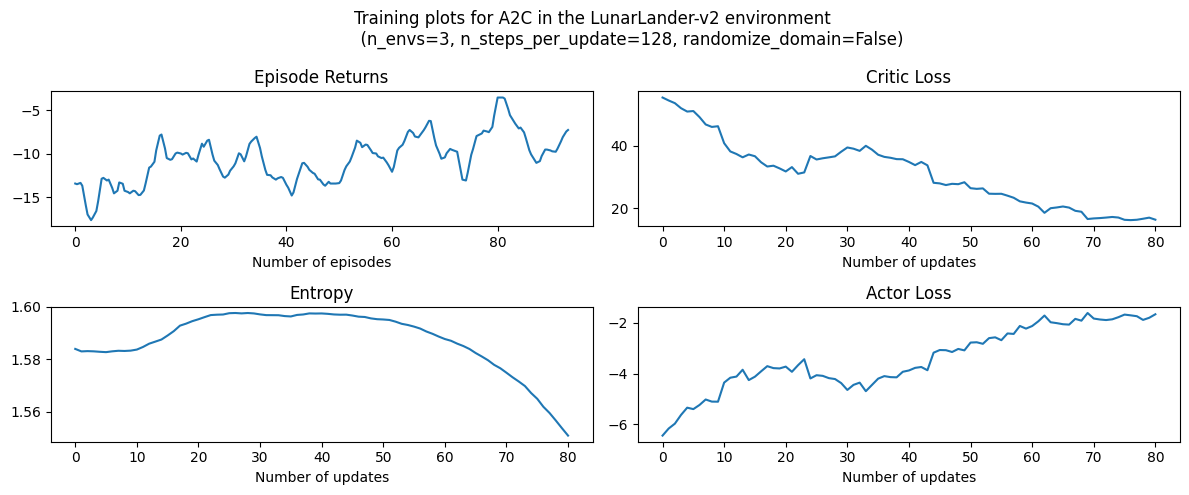

In [9]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the LunarLander-v2 environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()


In [10]:
save_weights = False
load_weights = False

actor_weights_path = "weights/actor_weights.h5"
critic_weights_path = "weights/critic_weights.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

In [12]:
""" play a couple of showcase episodes """

n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    env = BasketballEnv()

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :])

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...
reset!
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
Alice_alive
['=', '0']
!
0
0
Murder_Bat_Downtown_clues
['=', '1']
!
1
1
0
2
Sherlock
!!
1
!!
suspect_of_crime(Sherlock, Charlie, Murder, Bat, Downtown) arrest(Sherlock, Charlie, Downtown, Murder)
suspect_of_crime Sherlock Charlie Murder Bat Downtown
Charlie_suspect
['=', 'Murder']
!
Murder
Murder
0
2
Sherlock
!!
1
!!
arrest(Sherlock, Charlie, Downtown, Murder)
arrest Sherlock Charlie Downtown Murder
Charlie_underArrest
['=', '1']
!
1
1
1
2
starting episode 1...
reset!
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
Alice_alive
['=', '0']
!
0
0
Murder_Bat_Downtown_clues
['=', '1']
!
1
1
0
2
Sherlock
!!
1
!!
find_clues(Sherlock, Murder, Bat, Downtown)
find_clues Sherlock Murder Bat Downtown
Downtown_searched
['=', '1']
!
1
1
0
2
Alice
!!
1
!!
No solution exists.
0
2
Alice
!!
1
!!
No solution exists.
0
2
Sherlock
!!
1
!!
suspect_of_crime(Sherlock, Charlie, M